# CorolPor XSVS analysis

# XSVS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"
This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* XSVS analysis
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and Scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [22]:
import numpy as np
from datetime import datetime
import os
import time
from IPython.display import FileLink, display 
import matplotlib.pyplot as plt
%matplotlib notebook

import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import skbeam.core.speckle as spe
import skbeam.core.utils as utils
import skbeam.core.mask as sb_mask
from skbeam.core.fitting.lineshapes import nbinom_dist, poisson_dist

from lmfit import  Model
from scipy.interpolate import UnivariateSpline

from chxanalys.chx_libs import getpass, db
from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, load_data, load_mask,
                                             apply_mask, get_each_frame_intensity,
                                             create_hot_pixel_mask)
from chxanalys.XPCS_SAXS import get_circular_average, get_ring_mask, get_each_ring_mean_intensity
from chxanalys.Two_Time_Correlation_Function import (Get_Pixel_Array, auto_two_Array,show_C12,
                                                     get_one_time_from_two_time)

In [3]:
CYCLE = '2016_2'
uid =   'a7a76b' 

In [4]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1050--a7a76b79-3f5d-4482-8ce5-86b07663db3d--/XF11ID/data/2016/06/21/de184435-0cc9-4f57-8392_2361


In [5]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/06/21/de184435-0cc9-4f57-8392_2361_master.h5


In [6]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [7]:
md

{'beam_center_x': 1609.0,
 'beam_center_y': 291.0,
 'count_time': 0.099990003,
 'detector_distance': 4.8400002,
 'frame_time': 0.1,
 'framerate': 9.9999998509883898,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [9]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

center = [   1162,1547  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)


[1547, 1162]


In [10]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)
setup_pargs

{'Ldet': 4840.0,
 'center': [1547, 1162],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.099990003,
 'uid': 'a7a76b'}

<IPython.core.display.Javascript object>


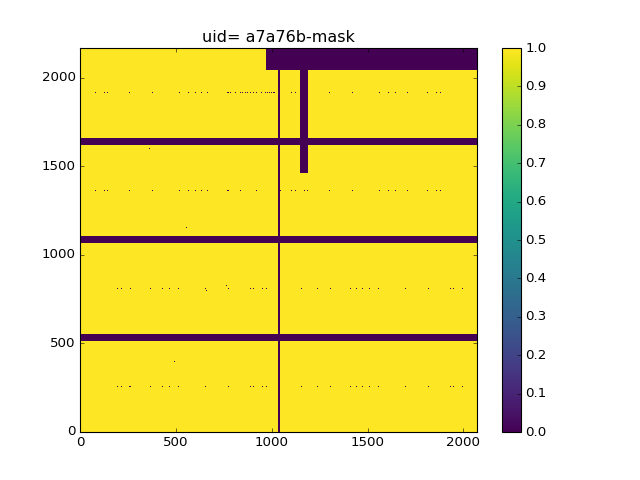

In [14]:
mask_path = '/XF11ID/analysis/2016_2/Commissioning/Corapor/Resutls/'
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'a7a76b_mask.npy'
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

100%|██████████| 10000/10000 [31:16<00:00,  6.14it/s]


<IPython.core.display.Javascript object>


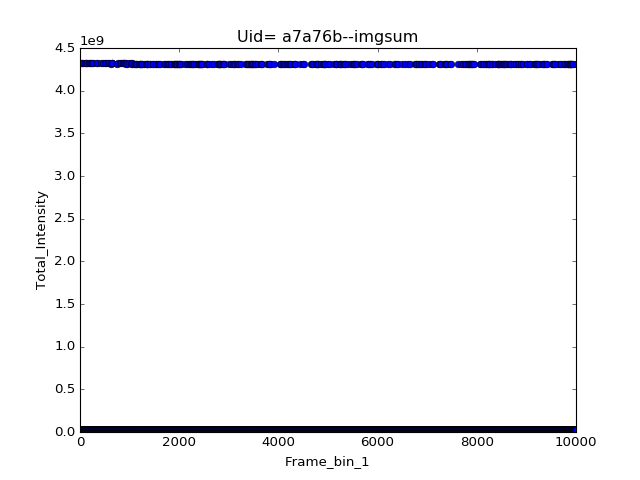

Bad frame list are: [   6   11   40   52  103  111  130  141  188  195  228  236  266  348  349
  425  471  510  519  562  578  635  640  644  650  749  765  810  835  865
  871  888  894  904  919  929  945  996 1023 1046 1049 1053 1096 1109 1120
 1123 1142 1197 1204 1205 1218 1233 1244 1248 1288 1324 1352 1353 1359 1376
 1402 1409 1476 1480 1527 1542 1567 1598 1619 1690 1707 1751 1770 1785 1826
 1836 1889 1900 1906 1911 1928 1953 1963 1965 1988 1990 1996 2012 2040 2117
 2157 2193 2217 2235 2256 2269 2278 2300 2343 2382 2384 2404 2409 2412 2426
 2433 2434 2454 2467 2553 2564 2566 2596 2657 2701 2786 2790 2803 2805 2811
 2817 2830 2840 2874 2893 2902 2908 3003 3054 3086 3104 3106 3123 3161 3192
 3208 3245 3347 3353 3371 3388 3400 3402 3440 3451 3465 3473 3490 3497 3523
 3530 3541 3586 3641 3655 3675 3770 3812 3813 3827 3830 3905 4032 4047 4055
 4097 4119 4125 4167 4196 4212 4227 4249 4320 4334 4338 4431 4498 4507 4663
 4679 4696 4749 4763 4778 4789 4793 4800 4865 4909 4913 4920 4938 49

In [15]:
imgsa = apply_mask( imgs, mask )
good_series = apply_mask(imgsa[0:], mask)
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1, 
                                bad_pixel_threshold=1.2e8,  plot_ = True, uid=uid)

## Create the "labels" or Ring mask for the analysis

In [18]:
inner_radius= 100
outer_radius = 520
width = 2
num_rings = 6

ring_mask, q_ring_center, q_ring_val = get_ring_mask(mask=mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs)

## Mean intensities of each ring

<IPython.core.display.Javascript object>


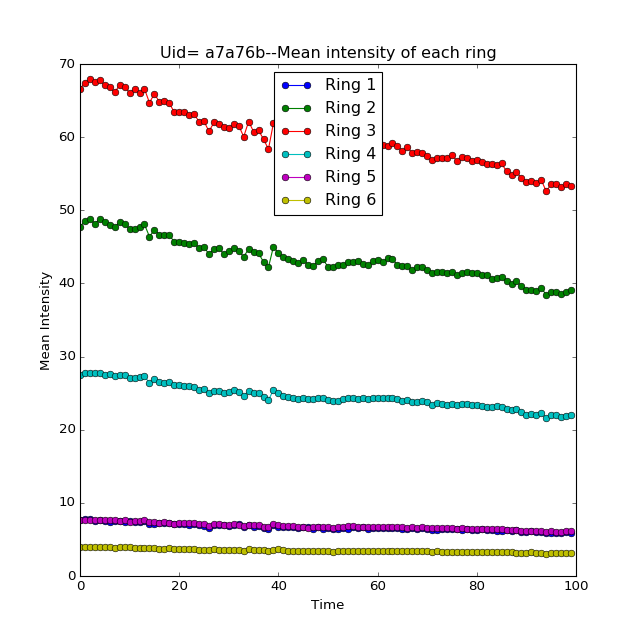

In [23]:
mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling=100,
                                             timeperframe=md['frame_time'], plot_=True,
                                             uid = uid)

## multi-tau one-time corrletaion analysis

In [24]:
num_lev =12
num_buf= 8

imgs_ = sb_mask.bad_to_nan_gen(good_series, bad_frame_list)

t0 = time.time()
g2, lag_steps  = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, imgs_)
t1 = time.time() - t0
t1

957.555585861206

In [26]:
taus = lag_steps * timeperframe
#res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid)

<IPython.core.display.Javascript object>


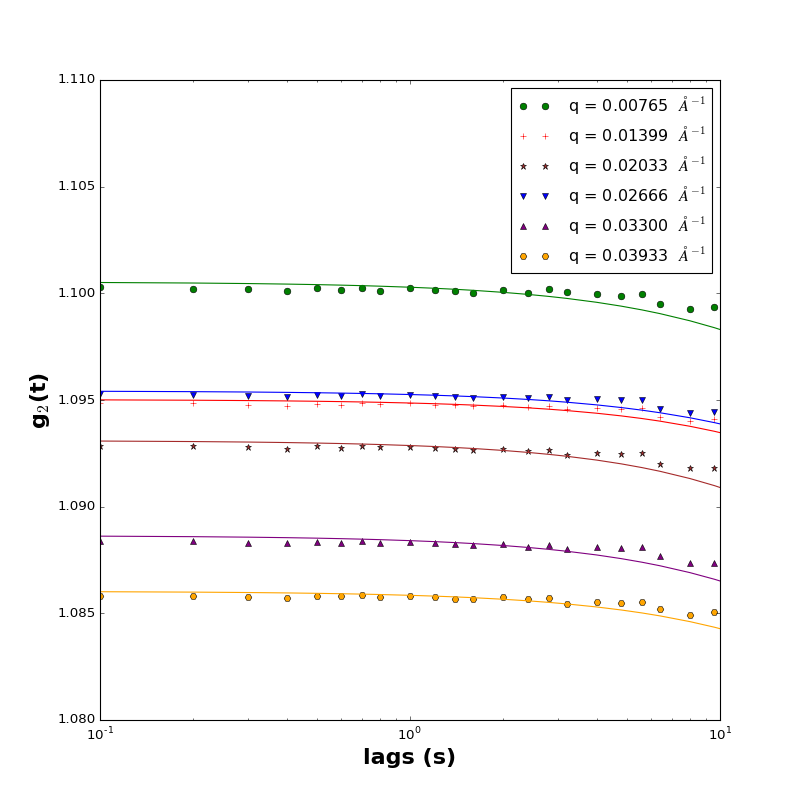

In [28]:
mod = Model(corr.auto_corr_scat_factor)  ##  Use lmfit Model 

axis_font = {'fontname':'Arial', 'size':'20', 'fontweight':'bold'}
axis_font2 = {'fontname':'Arial', 'size':'14', 'fontweight':'bold'}

rate3 = []
fig, axes = plt.subplots(1, figsize=(10, 10))
roi_names = ["green", "red", "brown", "blue", "purple", "orange"]
marks = ["o", "+", "*", "v", "^",  "H",]
for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    y = g2[1:, i]
    result3 = mod.fit(y, lags=lag_steps[1:], beta=.1,
                     relaxation_rate =.01, baseline=1.0)
    rate3.append(result3.best_values['relaxation_rate'])
    axes.semilogx(taus[1:], g2[1:, i], mark, markerfacecolor=roi_color, color=roi_color,
                  markersize=6, label=" q = " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    axes.semilogx(taus[1:], result3.best_fit, '-', c=roi_color)
axes.set_ylabel("g$_{2}$(t)", **axis_font)
axes.set_xlabel("lags (s)", **axis_font)
axes.set_xlim(0, 10**1)
axes.set_ylim(1.08, 1.11)
axes.legend(loc=1)
plt.show()

## XSVS analysis

In [40]:
def diff_mot_con_factor(times, relaxation_rate,
                        contrast_factor, cf_baseline=0):
    """
    This will provide the speckle contrast factor of samples undergoing
    a diffusive motion.

    Parameters
    ----------
    times : array
        integration times

    relaxation_rate : float
        relaxation rate

    contrast_factor : float
        contrast factor

    cf_baseline : float, optional
        the baseline for the contrast factor

    Return
    ------
    diff_contrast_factor : array
        speckle contrast factor for samples undergoing a diffusive motion

    Notes
    -----
    integration times more information - geometric_series function in
    skxray.core.utils module

    These implementations are based on the references under
    negative_binom_distribution() function Notes

    """
    co_eff = (np.exp(-2*relaxation_rate*times) - 1 +
              2*relaxation_rate*times)/(2*(relaxation_rate*times)**2)

    return contrast_factor*co_eff + cf_baseline

In [29]:
time_steps = utils.geometric_series(2, 10)
time_steps

[1, 2, 4, 8]

In [32]:
K_mean = np.mean(mean_int_sets[1], axis=0)
K_mean

array([  6.68569444,  43.38012948,  59.90743823,  24.60675025,
         6.8171295 ,   3.48953878])

In [34]:
max_cts = 60
imgs_ = sb_mask.bad_to_nan_gen(good_series, bad_frame_list)
spe_cts_all, std_dev = spe.xsvs((imgs_,), np.int_(ring_mask), timebin_num=2,
                             number_of_img=200, max_cts=int(max_cts+2))

/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(8, 2) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [35]:
Knorm_bin_edges, Knorm_bin_centers = spe.normalize_bin_edges(len(time_steps),
                                                            num_rings, K_mean, int(max_cts+2))

<IPython.core.display.Javascript object>


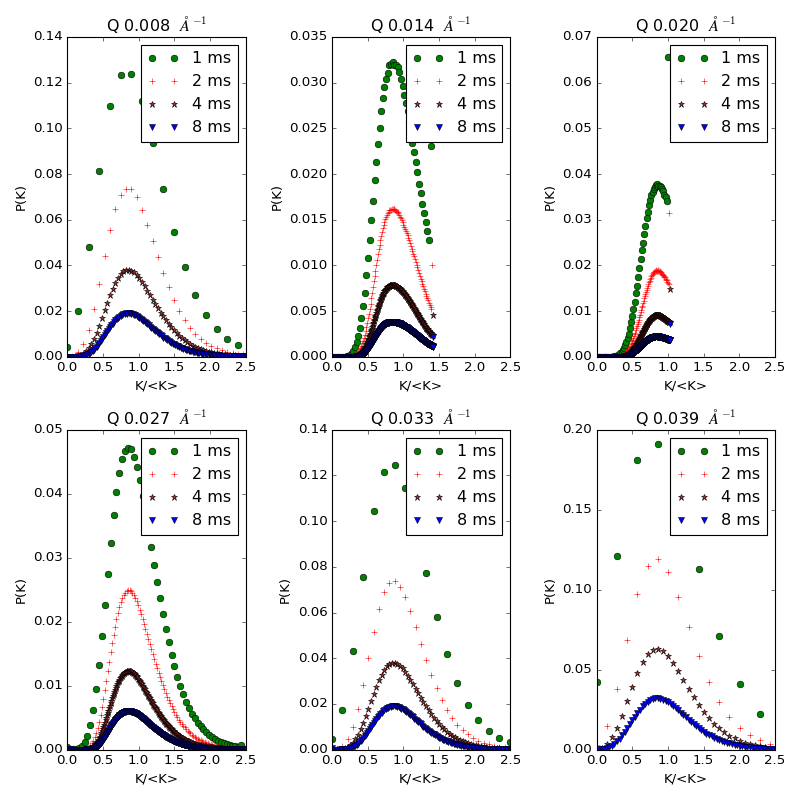

In [41]:
sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
roi_names = ["green", "red", "brown", "blue", "purple", "orange"]
marks = ["o", "+", "*", "v", "^",  "H",]
fig = plt.figure(figsize=(10, 10))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    for j, mark, roi_color  in zip(range(len(time_steps)), marks, roi_names):
        axes = fig.add_subplot(sx, sy, i+1 )
        axes.set_xlabel("K/<K>")
        axes.set_ylabel("P(K)")
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                     label=str(time_steps[j])+" ms")
        axes.set_xlim(0, 2.5)
        axes.set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes.legend()
plt.show()
fig.tight_layout()  

In [37]:
num_times = spe_cts_all.shape[0]
norm_bin_edges = np.zeros((num_times, num_rings), dtype=object)
bin_edges = np.zeros_like(norm_bin_edges)
for i in range(num_times):
    for j in range(num_rings):
        bin_edges[i, j] = np.arange(int(max_cts +2 )*2**i)  

In [65]:
n_mod = Model(nbinom_dist)
dc_mod = Model(diff_mot_con_factor)

<IPython.core.display.Javascript object>


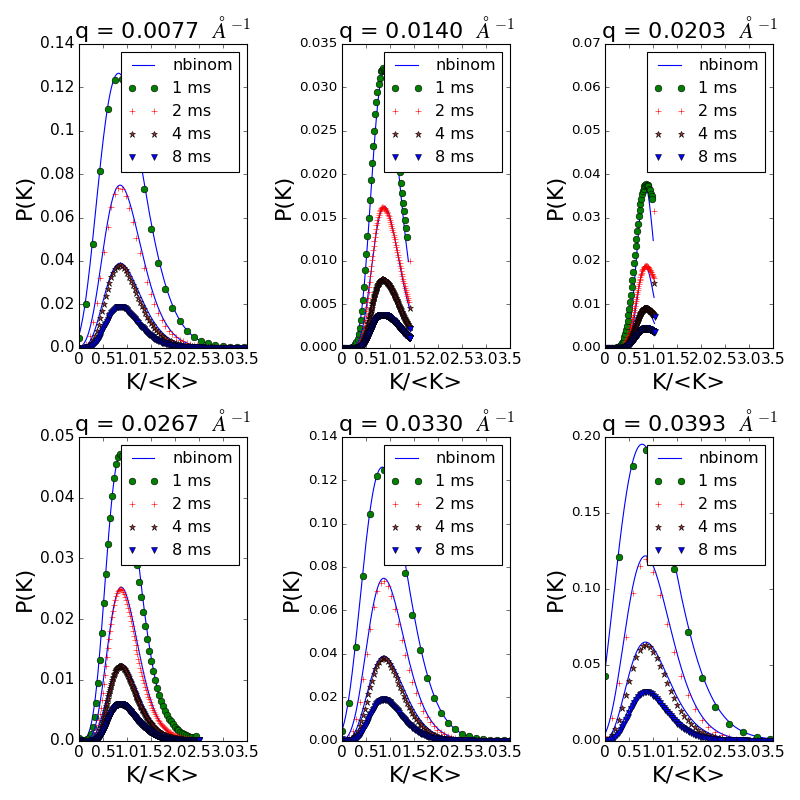

/opt/conda_envs/analysis/lib/python3.4/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [44]:
M_val = {}
K_val = {}
sx = int(round(np.sqrt(num_rings)))
axis_font = {'fontname':'Arial', 'size':'20'}
axis_font2 = {'fontname':'Arial', 'size':'14'}
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
fig = plt.figure(figsize=(10, 10))
plt.title('uid= %s'%uid+" Fitting with Negative Binomial Function", fontsize=20, y=1.02)  
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    M_val[i]=[]
    K_val[i]=[]
    for j, mark, roi_color in zip(range(len(time_steps)), marks,roi_names):
        # find the best values for K and M from fitting
        result_n = n_mod.fit(spe_cts_all[j, i],
                             bin_values=bin_edges[j, i][:-1],
                             K=5, M=12)
        M_val[i].append(result_n.best_values['M'])
        K_val[i].append(result_n.best_values['K'])
        axes = fig.add_subplot(sx, sy, i+1 )
        #axes = fig.add_subplot(2, 2, 1)
        axes.set_xlabel("K/<K>", **axis_font)
        axes.set_ylabel("P(K)", **axis_font)
        
        #  Using the best K and M values interpolate and get more values for fitting curve
        fitx_ = np.linspace(0, max(Knorm_bin_edges[j, i][:-1]), 10000*2**j   )   
        
        fitx = np.linspace(0, max(bin_edges[j, i][:-1]), 10000*2**j   )         
        fity = nbinom_dist( fitx, K_val[i][j], M_val[i][j] ) # M and K are fitted best values

        
        if j == 0:
            art, = axes.plot(fitx_,fity, '-b',  label="nbinom")
        else:
            art, = axes.plot(fitx_,fity, '-b')
            
        art, = axes.plot(Knorm_bin_edges[j, i][:-1], spe_cts_all[j, i], mark, color=roi_color,
                     label=str(time_steps[j])+" ms")
        
        axes.set_xlim(0, 3.5)
        # Annotate the best K and M values on the plot
        #axes.annotate(r'K='+'%.3f'%( K_val[i][0]) +','+r'M='+'%.3f'%(M_val[i][0]),
        #              xy=(1, 0.25),
        #              xycoords='axes fraction', fontsize=16,
        #              horizontalalignment='right', verticalalignment='bottom')
        axes.set_title("q = "+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$', **axis_font)
        axes.legend()
        #axes.set_yticklabels([1150, 1200, 1250, 1300, 1350, 1400], **axis_font)
        axes.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], **axis_font2)
        if i==0:
            axes.set_yticklabels([0.00, 0.02, 0.04, 0.06, 0.08, 0.10,
                                  0.12, 0.14], **axis_font2)
        elif i==3:
            axes.set_yticklabels([0.00, 0.01, 0.02, 0.03, 0.04, 0.05], **axis_font2)
plt.show()
fig.tight_layout()  

## Get the contast factor of detected signals is 1/M
## β=1/M

In [55]:
contrast_factor = np.zeros((num_rings, len(time_steps)))

for i in range(num_rings):
    for j in range(len(time_steps)):
        contrast_factor[i, j] =  1/M_val[i][j]
contrast_factor  

array([[ 0.09561387,  0.0999692 ,  0.12526168,  0.14102668],
       [ 0.07224391,  0.07999256,  0.08856139,  0.09574872],
       [ 0.02380336,  0.03294492,  0.03963182,  0.04435899],
       [ 0.09051702,  0.09491897,  0.10513226,  0.11311334],
       [ 0.08806125,  0.09312352,  0.11784067,  0.13316819],
       [ 0.08850717,  0.09639162,  0.14126183,  0.16681858]])

<IPython.core.display.Javascript object>


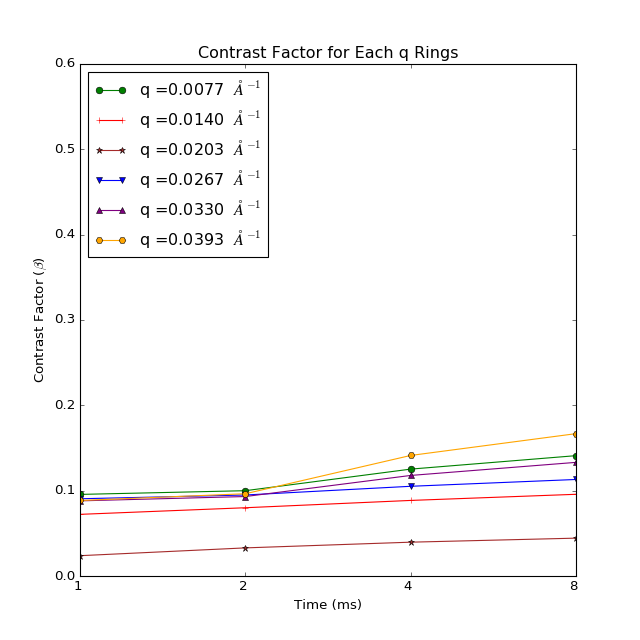

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
for i, roi_color, mark in zip(range(num_rings), roi_names, marks):
    ax.plot(contrast_factor[i, :], marker=mark, color=roi_color,
            label="q ="+ '%.4f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
    ax.set_ylabel("Contrast Factor " r'($\beta $)')
ax.set_title("Contrast Factor for Each q Rings")
ax.set_xlabel("Time (ms)")
ax.legend(loc=2)
ax.set_xticks([j for j in range(6)])
ax.set_xticklabels(['%i ' % time_steps[j] for j in range(len(time_steps))])
ax.set_ylim(0, 0.6)
ax.set_xlim(0, 3)
plt.show()

In [90]:
relax_rate = []
dc_mod
for i in range(num_rings):
    result_dc = dc_mod.fit(contrast_factor[i, :], times=time_steps,
                           relaxation_rate=1.0, contrast_factor=0.78, cf_baseline=0)
    relax_rate.append(result_dc.best_values['relaxation_rate'])
    
relax_rate

[0.22683436827261055,
 0.51014011288351258,
 1.1315654267815494,
 0.27821493099831945,
 0.24307271755992702,
 0.25127713580633815]

<IPython.core.display.Javascript object>


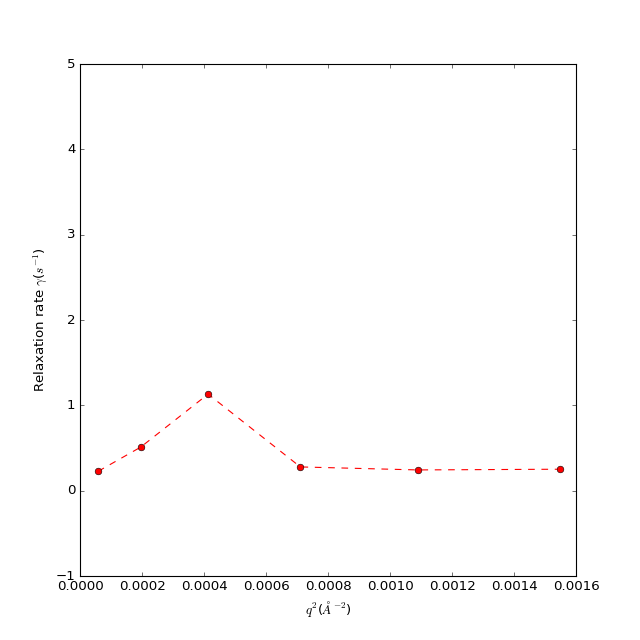

In [67]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(q_ring_center**2, relax_rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
ax.set_ylim(-1, 5)
plt.show()


In [91]:
relax = relax_rate
qs = (q_ring_center**2).tolist()
del qs[2]
del relax[2]

## Relaxtaion Rate

<IPython.core.display.Javascript object>


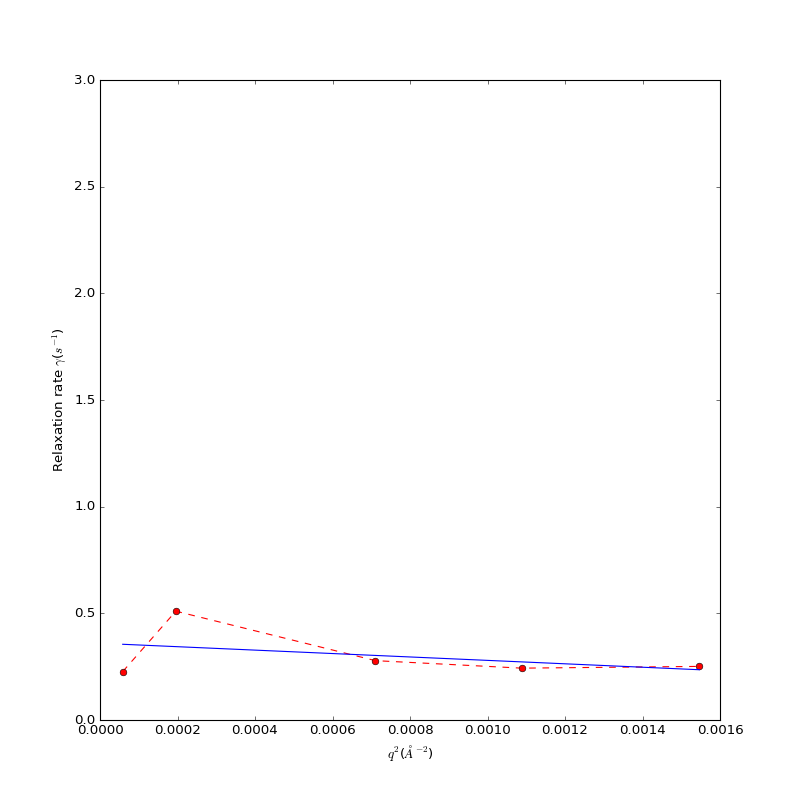

In [100]:
D0 = np.polyfit(qs, relax, 1)
gmfit = np.poly1d(D0)

fig, ax = plt.subplots(figsize=(10, 10) )
ax.plot(qs, relax, 'ro', ls='--')
ax.plot(qs,  gmfit(qs),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
ax.set_ylim(0, 3)
plt.show()